<a href="https://colab.research.google.com/github/Septiancesare/AI-Dataset/blob/main/AI_UAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Transfer Learning (Klasifikasi Pakaian)**
Terdiri dari 4 Kelas: Kaos, Kemeja, Celana Panjang dan Celana Pendek

# **Import dan Ekstrak Data**

persiapkan library dan dependencies yang diperlukan seperti gdown untuk download data, OpenCV untuk pengolahan gambar, serta matplotlib untuk visualisasi sebelum membangun model klasifikasi.

In [ ]:
!pip install gdown

In [ ]:
import gdown
import zipfile
import os
import pandas as pd
from pathlib import Path
import cv2
import numpy as np
import random
import os
import matplotlib.pyplot as plt

In [ ]:
url = "https://drive.google.com/file/d/11mZmx42gcC8Jai3DcAtTBjOH-WooNc6q/view?usp=sharing"


file_id = url.split('/d/')[1].split('/')[0]
print(f"File ID: {file_id}")
output_zip = "Dataset_AI.zip"

gdown.download(f"https://drive.google.com/uc?id={file_id}", output_zip, quiet=False)

if os.path.exists(output_zip):
    file_size = os.path.getsize(output_zip) / (1024**2)
    print(f"File size: {file_size:.2f} MB")
else:
    raise FileNotFoundError("File tidak ditemukan setelah download")

File ID: 11mZmx42gcC8Jai3DcAtTBjOH-WooNc6q


Downloading...
From (original): https://drive.google.com/uc?id=11mZmx42gcC8Jai3DcAtTBjOH-WooNc6q
From (redirected): https://drive.google.com/uc?id=11mZmx42gcC8Jai3DcAtTBjOH-WooNc6q&confirm=t&uuid=bf9d6765-edce-459e-a68e-b3374f225cb3
To: /content/Dataset_AI.zip
100%|██████████| 278M/278M [00:01<00:00, 149MB/s]

File size: 265.06 MB


Dilanjutkan mendownload dan mengekstrak dataset dari Google Drive ke lingkungan kerja lokal menggunakan file ID yang diekstrak dari url.

In [ ]:
extract_to = "/content/dataset_ai"
os.makedirs(extract_to, exist_ok=True)

with zipfile.ZipFile(output_zip, 'r') as zip_ref:
    file_list = zip_ref.namelist()
    print(f"Total {len(file_list)} item")


    print("\n File :")
    for i, file_name in enumerate(file_list[:10]):
        print(f"  {i+1:2d}. {file_name}")

    if len(file_list) > 10:
        print(f"  ... dan {len(file_list) - 10} file lainnya")

    zip_ref.extractall(extract_to)


Total 270 item

 File :
   1. Kaos/
   2. Kaos/Kaos 1.jpg
   3. Kaos/Kaos 10.jpg
   4. Kaos/Kaos 11.jpg
   5. Kaos/Kaos 12.jpg
   6. Kaos/Kaos 13.jpg
   7. Kaos/Kaos 14.jpg
   8. Kaos/Kaos 15.jpg
   9. Kaos/Kaos 16.jpg
  10. Kaos/Kaos 17.jpg
  ... dan 260 file lainnya


dataset yang telah diekstrak kemudian dihitung total file, ukuran keseluruhan, serta struktur folder dan distribusi tipe file untuk memahami organisasi data sebelum diproses lebih lanjut.

In [ ]:
def explore_extracted_dataset(base_path="/content/dataset_ai"):

    total_files = 0
    total_size = 0
    file_types = {}

    for root, dirs, files in os.walk(base_path):
        total_files += len(files)

        # Analisis tipe file
        for file in files:
            file_path = os.path.join(root, file)
            file_ext = os.path.splitext(file)[1].lower()

            # Hitung ukuran file
            try:
                file_size = os.path.getsize(file_path)
                total_size += file_size
            except:
                file_size = 0

            # Kategorikan berdasarkan ekstensi
            if file_ext:
                file_types[file_ext] = file_types.get(file_ext, 0) + 1

    print(f"Total file: {total_files}")
    print(f"Total ukuran: {total_size / (1024**2):.2f} MB")
    print(f"Struktur folder:")

    # Tampilkan struktur folder
    for root, dirs, files in os.walk(base_path):
        level = root.replace(base_path, '').count(os.sep)
        indent = ' ' * 2 * level
        print(f'{indent}{os.path.basename(root)}/')
        subindent = ' ' * 2 * (level + 1)
        for file in files[:5]:
            print(f'{subindent}{file}')
        if len(files) > 5:
            print(f'{subindent}... dan {len(files) - 5} file lainnya')

    print(f"\n tipe file:")
    for ext, count in sorted(file_types.items(), key=lambda x: x[1], reverse=True):
        print(f"   • {ext}: {count} file")

    return total_files, file_types

# Jalankan eksplorasi
total_files, file_types = explore_extracted_dataset()

Total file: 266
Total ukuran: 269.28 MB
Struktur folder:
dataset_ai/
  Celana Panjang/
    panjang 15.jpg
    Panjang 21.jpg
    panjang 6.jpg
    Panjang 28.jpg
    panjang 56.jpg
    ... dan 57 file lainnya
  Celana pendek/
    pendek 49.jpg
    pendek 1.jpg
    pendek 51.jpg
    pendek 2.jpg
    pendek 28.jpg
    ... dan 52 file lainnya
  Kaos/
    Kaos 31.jpg
    Kaos 9.jpg
    Kaos 12.jpg
    Kaos 5.jpg
    Kaos 27.jpg
    ... dan 67 file lainnya
  Kemeja/
    Kemeja 56.jpg
    Kemeja 11.jpg
    Kemeja 1.jpg
    Kemeja 68.jpg
    Kemeja 43.jpg
    ... dan 70 file lainnya

 tipe file:
   • .jpg: 266 file


# **Augmentasi Dataset**

siapkan berbagai teknik augmentasi data gambar seperti rotasi, flip, kecerahan, dan transformasi geometris untuk meningkatkan variasi dataset, dilengkapi dengan fungsi visualisasi dan aplikasi batch pada seluruh dataset.

In [ ]:
def rotate_image(image, angle): # Memutar gambar
    h, w = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h))
    return rotated

def flip_horizontal(image): # membalik secara gorizontal

    return cv2.flip(image, 1)

def flip_vertical(image): # membalik secara vertikal
    return cv2.flip(image, 0)

def adjust_brightness(image, factor): # menagtur kecerahan
    """
    factor > 1: lebih terang
    factor < 1: lebih gelap
    """
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hsv[:, :, 2] = np.clip(hsv[:, :, 2] * factor, 0, 255)
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

def adjust_contrast(image, factor): # mengatur kontras
    mean = np.mean(image)
    contrasted = np.clip((image - mean) * factor + mean, 0, 255).astype(np.uint8)
    return contrasted

def adjust_saturation(image, factor): # mengatur saturasi warna gambarr
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hsv[:, :, 1] = np.clip(hsv[:, :, 1] * factor, 0, 255)
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

def adjust_sharpness(image, factor): # mengatur ketajaman gambar
    kernel = np.array([[-1, -1, -1],
                       [-1,  9, -1],
                       [-1, -1, -1]]) * factor
    sharpened = cv2.filter2D(image, -1, kernel)
    return np.clip(sharpened, 0, 255).astype(np.uint8)

def apply_blur(image, kernel_size=(5,5)): # menggaburkan gambar
    return cv2.GaussianBlur(image, kernel_size, 0)

def random_crop(image, crop_percent=0.8): # memotong gambar secara random
    h, w = image.shape[:2]
    crop_h = int(h * crop_percent)
    crop_w = int(w * crop_percent)
    y = random.randint(0, h - crop_h)
    x = random.randint(0, w - crop_w)
    return image[y:y+crop_h, x:x+crop_w]

def random_zoom(image, zoom_range=(0.8, 1.2)): # zoom in/out gambar
    zoom_factor = random.uniform(zoom_range[0], zoom_range[1])
    h, w = image.shape[:2]
    new_h, new_w = int(h * zoom_factor), int(w * zoom_factor)
    resized = cv2.resize(image, (new_w, new_h))
    if zoom_factor > 1:
        # Crop tengah jika zoom in
        start_h = (new_h - h) // 2
        start_w = (new_w - w) // 2
        return resized[start_h:start_h+h, start_w:start_w+w]
    else:
        # Tambah border jika zoom out
        top = (h - new_h) // 2
        bottom = h - new_h - top
        left = (w - new_w) // 2
        right = w - new_w - left
        return cv2.copyMakeBorder(resized, top, bottom, left, right, cv2.BORDER_CONSTANT)

def translate_image(image, tx, ty): #mentraslasikan gambar
    h, w = image.shape[:2]
    M = np.float32([[1, 0, tx], [0, 1, ty]])
    return cv2.warpAffine(image, M, (w, h))

def shear_image(image, shear_factor): # memiringkan gambar
    h, w = image.shape[:2]
    M = np.float32([[1, shear_factor, 0], [0, 1, 0]])
    return cv2.warpAffine(image, M, (w, h))

def color_jitter(image, brightness=0.2, contrast=0.2, saturation=0.2):  #Kombinasi brightness, contrast, saturation.
    img = image.copy()
    if brightness:
        img = adjust_brightness(img, 1 + random.uniform(-brightness, brightness))
    if contrast:
        img = adjust_contrast(img, 1 + random.uniform(-contrast, contrast))
    if saturation:
        img = adjust_saturation(img, 1 + random.uniform(-saturation, saturation))
    return img

def random_erase(image, erase_area=0.1): #menghapus bagian gambar secara random
    h, w = image.shape[:2]
    erase_h = int(h * erase_area)
    erase_w = int(w * erase_area)
    y = random.randint(0, h - erase_h)
    x = random.randint(0, w - erase_w)
    erased = image.copy()
    erased[y:y+erase_h, x:x+erase_w] = np.random.randint(0, 256, (erase_h, erase_w, 3), dtype=np.uint8)
    return erased

def augment_image(image): # Menerapkan serangkaian augmentasi secara random pada gambar.
    img = image.copy()

    # Rotasi
    if random.choice([True, False]):
        angle = random.randint(-30, 30)
        img = rotate_image(img, angle)

    # Flip
    if random.choice([True, False]):
        img = flip_horizontal(img)
    if random.choice([True, False]):
        img = flip_vertical(img)

    # Color Jitter (brightness, contrast, saturation)
    if random.choice([True, False]):
        img = color_jitter(img, brightness=0.3, contrast=0.3, saturation=0.3)

    # Sharpness
    if random.choice([True, False]):
        img = adjust_sharpness(img, factor=random.uniform(0.5, 1.5))

    # Blur
    if random.choice([True, False]):
        img = apply_blur(img)

    # Random Crop
    if random.choice([True, False]):
        img = random_crop(img, crop_percent=random.uniform(0.7, 0.95))

    # Random Zoom
    if random.choice([True, False]):
        img = random_zoom(img, zoom_range=(0.8, 1.3))

    # Translation
    if random.choice([True, False]):
        tx = random.randint(-50, 50)
        ty = random.randint(-50, 50)
        img = translate_image(img, tx, ty)

    # Shear
    if random.choice([True, False]):
        shear = random.uniform(-0.3, 0.3)
        img = shear_image(img, shear)

    # Random Erase
    if random.choice([True, False]):
        img = random_erase(img, erase_area=random.uniform(0.05, 0.2))

    return img

def visualize_augmentations(base_path, num_examples=3): # Menampilkan contoh hasil augmentasi untuk visualisasi.
    # Cari file gambar di dataset
    image_files = []
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_files.append(os.path.join(root, file))

    if not image_files:
        print("Gambar tidak ditemukan")
        return

    # Ambil contoh gambar
    sample_images = random.sample(image_files, min(num_examples, len(image_files)))

    # Tampilkan hasil augmentasi
    fig, axes = plt.subplots(num_examples, 4, figsize=(15, 4*num_examples))

    for i, img_path in enumerate(sample_images):
        # Baca gambar asli
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Tampilkan gambar asli
        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f"Original\n{os.path.basename(img_path)}")
        axes[i, 0].axis('off')

        # Tampilkan 3 contoh augmentasi
        for j in range(3):
            augmented = augment_image(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
            augmented_rgb = cv2.cvtColor(augmented, cv2.COLOR_BGR2RGB)
            axes[i, j+1].imshow(augmented_rgb)
            axes[i, j+1].set_title(f"Augmented {j+1}")
            axes[i, j+1].axis('off')

    plt.tight_layout()
    plt.show()

def augment_dataset(base_path, output_path, augment_per_image=5): #augmentasi seluruh data
    os.makedirs(output_path, exist_ok=True)
    total_original = 0
    total_augmented = 0

    for root, dirs, files in os.walk(base_path):
        # Buat struktur folder yang sama di output
        rel_path = os.path.relpath(root, base_path)
        save_dir = os.path.join(output_path, rel_path)
        os.makedirs(save_dir, exist_ok=True)

        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                file_path = os.path.join(root, file)
                image = cv2.imread(file_path)

                if image is None:
                    print(f"Gagal membaca: {file_path}")
                    continue

                # Simpan gambar asli
                cv2.imwrite(os.path.join(save_dir, file), image)
                total_original += 1

                # Buat gambar augmentasi
                for i in range(augment_per_image):
                    augmented = augment_image(image)
                    aug_filename = f"{os.path.splitext(file)[0]}_aug_{i+1}.jpg"
                    cv2.imwrite(os.path.join(save_dir, aug_filename), augmented)
                    total_augmented += 1

    print(f"Gambar asli: {total_original}")
    print(f"Gambar hasil augmentasi: {total_augmented}")
    print(f"Total gambar: {total_original + total_augmented}")
    print(f"Lokasi dataset hasil: {output_path}")



jalankan pipeline augmentasi data dengan menampilkan contoh visual transformasi, menerapkannya ke seluruh dataset, dan menampilkan statistik akhir berupa jumlah file dan ukuran dataset yang telah diperbanyak.

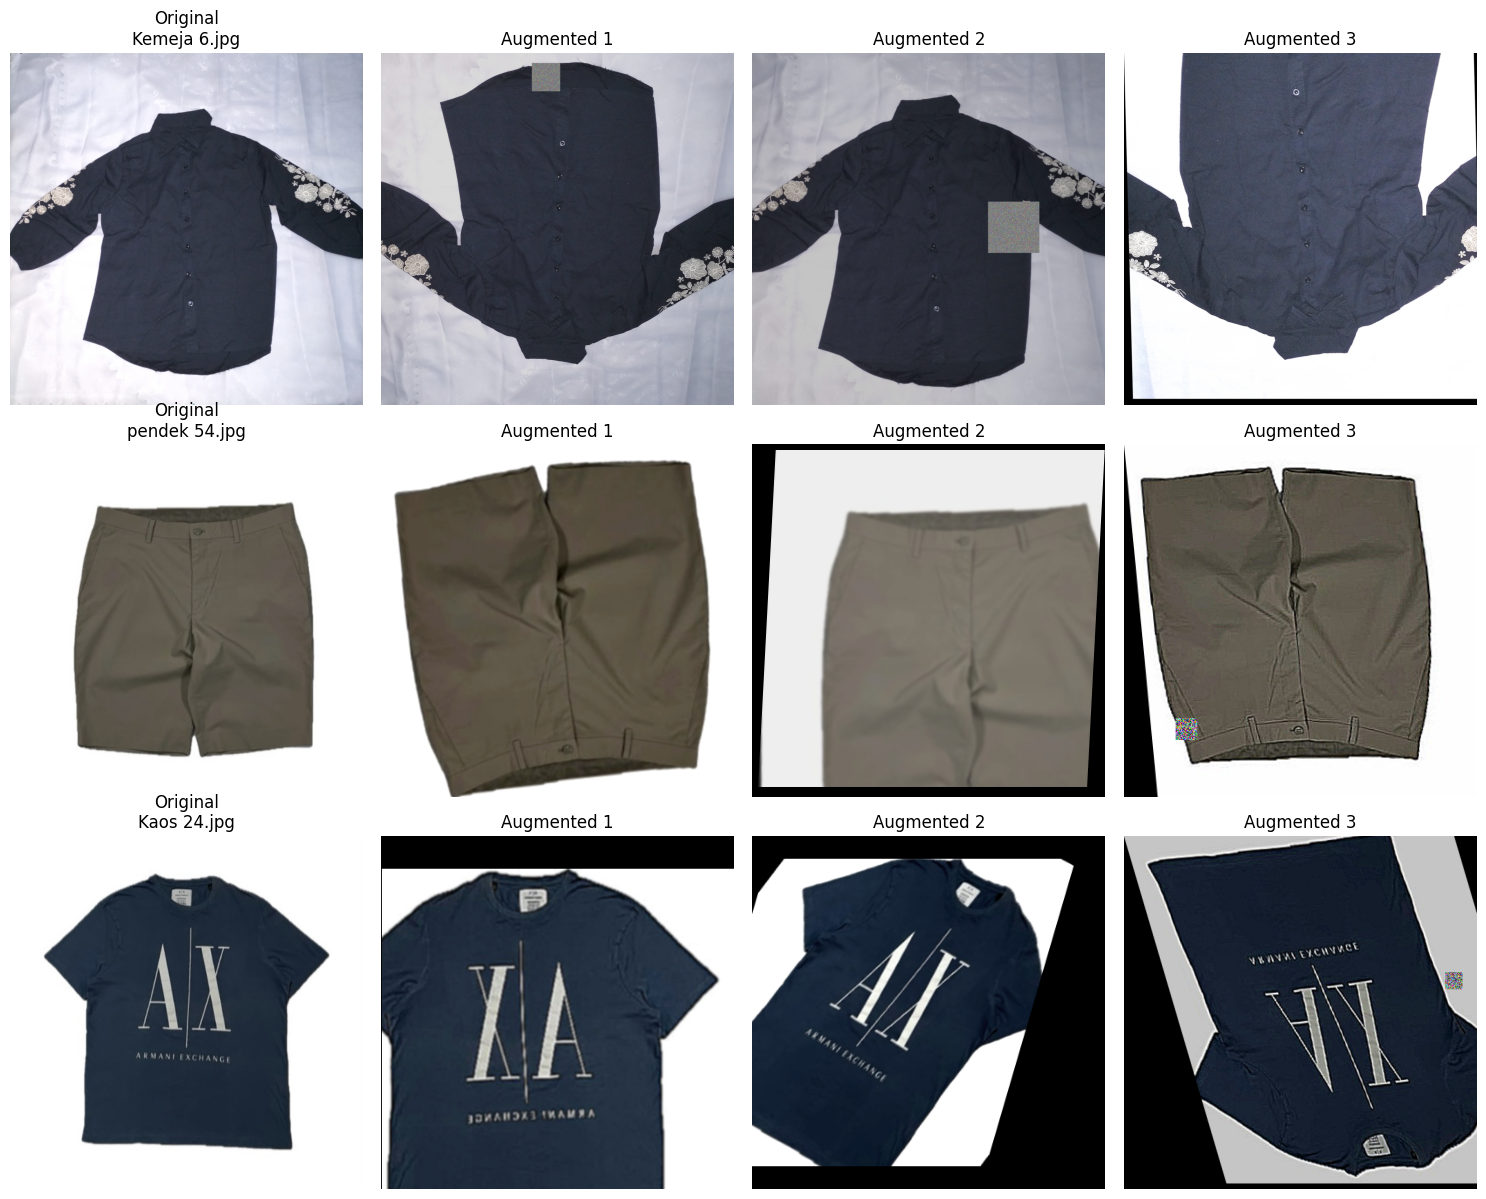

Gambar asli: 266
Gambar hasil augmentasi: 798
Total gambar: 1064
Lokasi dataset hasil: /content/dataset_ai_augmented
 dataset_ai_augmented/
   Celana Panjang/
     panjang 6_aug_3.jpg
     panjang 38_aug_3.jpg
     panjang 15.jpg
     panjang 48_aug_1.jpg
     panjang 49_aug_3.jpg
    ... dan 243 file lainnya
   Celana pendek/
     pendek 49.jpg
     pendek 50_aug_1.jpg
     pendek 52_aug_3.jpg
     pendek 1.jpg
     pendek 51.jpg
    ... dan 223 file lainnya
   Kaos/
     Kaos 25_aug_2.jpg
     Kaos 34_aug_3.jpg
     Kaos 20_aug_3.jpg
     Kaos 69_aug_1.jpg
     Kaos 69_aug_2.jpg
    ... dan 283 file lainnya
   Kemeja/
     Kemeja 56.jpg
     Kemeja 34_aug_3.jpg
     Kemeja 80_aug_1.jpg
     Kemeja 1_aug_3.jpg
     Kemeja 75_aug_3.jpg
    ... dan 295 file lainnya
   Total file: 1064
   Total ukuran: 1093.33 MB
   Distribusi tipe file:
     .jpg: 20 file


In [ ]:
if __name__ == "__main__":
    # Path dataset asli dan output
    base_path = "/content/dataset_ai"
    output_path = "/content/dataset_ai_augmented"

    # Install library jika diperlukan
    try:
        import cv2
        import numpy as np
    except ImportError:
        !pip install opencv-python numpy matplotlib

    # menampilkan contoh augmentasi
    visualize_augmentations(base_path, num_examples=3)

    # Jalankan augmentasi pada seluruh dataset
    augment_dataset(base_path, output_path, augment_per_image=3)

    # Tampilkan statistik dataset hasil
    total_files = 0
    file_types = {}
    folder_structure = {}

    for root, dirs, files in os.walk(output_path):
        level = root.replace(output_path, '').count(os.sep)
        indent = ' ' * 2 * level
        folder_name = os.path.basename(root) if root != output_path else 'dataset_ai_augmented'

        print(f"{indent} {folder_name}/")
        folder_structure[folder_name] = len(files)

        sub_indent = ' ' * 2 * (level + 1)
        file_count = 0
        for file in files[:5]:  # Tampilkan 5 file pertama
            print(f"{sub_indent} {file}")
            file_count += 1

            # Hitung tipe file
            file_ext = os.path.splitext(file)[1].lower()
            file_types[file_ext] = file_types.get(file_ext, 0) + 1

        if len(files) > 5:
            print(f"{sub_indent}... dan {len(files) - 5} file lainnya")

        total_files += len(files)

    print(f"   Total file: {total_files}")

    # Hitung ukuran total
    total_size = 0
    for root, dirs, files in os.walk(output_path):
        for file in files:
            try:
                total_size += os.path.getsize(os.path.join(root, file))
            except:
                pass

    print(f"   Total ukuran: {total_size / (1024**2):.2f} MB")
    print(f"   Distribusi tipe file:")
    for ext, count in sorted(file_types.items(), key=lambda x: x[1], reverse=True):
        print(f"     {ext}: {count} file")

# **Preprocessing Data**

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from pathlib import Path
from sklearn.model_selection import train_test_split
from torchvision.models import resnet50
import warnings
warnings.filterwarnings('ignore')

Konfigurasi Device yang digunakan. 'cuda' untuk GPU NVIDIA (jika ada)

In [ ]:
# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Menggunakan device: {device}")

Menggunakan device: cuda


Kustomisasi PyTorch Dataset yang membaca gambar pakaian dari folder terstruktur, menerapkan transformasi yang diperlukan, dan mempersiapkannya untuk pelatihan model dengan label kelas yang sesuai.

In [ ]:
class ClothingDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.classes = sorted([d.name for d in self.root_dir.iterdir() if d.is_dir()])
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

        self.image_paths = []
        self.labels = []

        # Kumpulkan semua gambar
        for class_name in self.classes:
            class_dir = self.root_dir / class_name
            class_idx = self.class_to_idx[class_name]

            for img_file in class_dir.glob("*.jpg"):
                self.image_paths.append(str(img_file))
                self.labels.append(class_idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        # Baca gambar dengan OpenCV
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Konversi ke PIL Image untuk transformasi torchvision
        from PIL import Image
        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        return image, label

Transformasi data untuk training, dan normalisasi standar ImageNet untuk menyiapkan gambar input model neural network.



In [ ]:
# Transform untuk training
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

# Transform untuk testing
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

# **LOAD DAN SPLIT DATASET**

Fungsi untuk membagi dataset menjadi training dan testing untuk menjaga distribusi kelas, serta menyediakan visualisasi sampel gambar setelah dinormalisasi untuk pemeriksaan data.

In [ ]:
def load_and_split_dataset(dataset_path, test_size=0.2, random_state=42):
    # Load dataset lengkap
    full_dataset = ClothingDataset(dataset_path, transform=train_transform)

    # Split indeks
    indices = list(range(len(full_dataset)))
    train_indices, test_indices = train_test_split(
        indices, test_size=test_size, random_state=random_state,
        stratify=full_dataset.labels
    )

    # Buat subset
    train_dataset = torch.utils.data.Subset(full_dataset, train_indices)
    test_dataset = torch.utils.data.Subset(full_dataset, test_indices)

    # Ganti transformasi untuk test dataset
    test_dataset.dataset.transform = test_transform

    return train_dataset, test_dataset, full_dataset.classes

def visualize_samples(dataset, num_samples=5):

    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))

    for i in range(num_samples):
        img, label = dataset[i]

        # Denormalize gambar
        img_np = img.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img_np = std * img_np + mean
        img_np = np.clip(img_np, 0, 1)

        axes[i].imshow(img_np)
        axes[i].set_title(f"Label: {classes[label]}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

Muat dataset yang telah diaugmentasi, membaginya menjadi training dan testing set, kemudian menampilkan informasi statistik seperti jumlah kelas dan sampel untuk setiap bagian.

In [ ]:
# Path dataset hasil augmentasi
dataset_path = "/content/dataset_ai_augmented"
batch_size = 32

# Load dataset
train_dataset, test_dataset, classes = load_and_split_dataset(dataset_path)
print(f"Total kelas: {len(classes)}")
print(f"Kelas: {classes}")
print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Total kelas: 4
Kelas: ['Celana Panjang', 'Celana pendek', 'Kaos', 'Kemeja']
Training samples: 851
Test samples: 213


Membuat data loader untuk training dan testing


Visualisasi sample gambar:


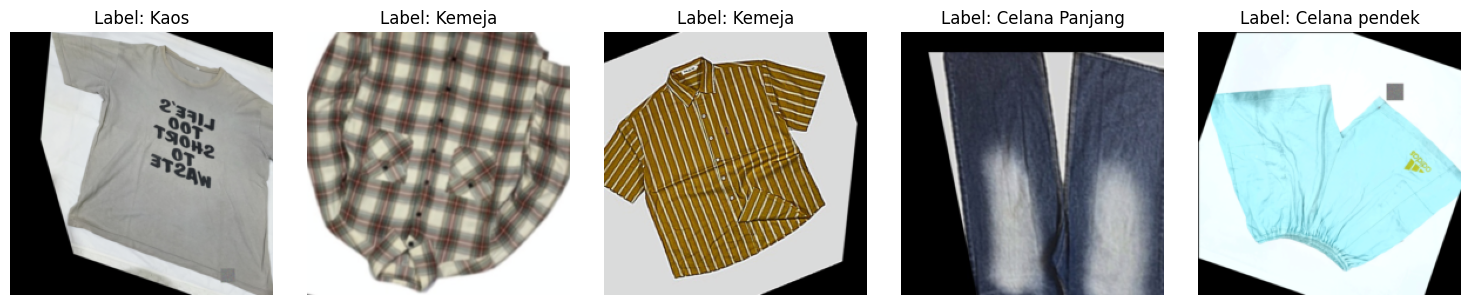

In [ ]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

print("\nVisualisasi sample gambar:")
visualize_samples(train_dataset)

# **Resnet50**

In [ ]:
def create_resnet50_model(num_classes):
    # Load pretrained ResNet50
    model = resnet50(weights='IMAGENET1K_V1')

    # Modify final fully connected layer
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(num_ftrs, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, num_classes)
    )

    return model

Definisikan hyperparameter pelatihan: jumlah kelas = 4, batch_size = 32 sampel per iterasi, learning_rate = 0.00001 untuk kontrol kecepatan pembelajaran, dan num_epochs = 5 iterasi lengkap melalui dataset.

In [ ]:
# Inisialisasi model
num_classes = len(classes)
model = create_resnet50_model(num_classes)
model = model.to(device)

print(f"\nModel ResNet50 dibuat:")
print(f"Jumlah kelas: {num_classes}")
print(f"Architecture fc layer: {model.fc}")

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 153MB/s]



Model ResNet50 dibuat:
Jumlah kelas: 4
Architecture fc layer: Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=2048, out_features=512, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.3, inplace=False)
  (4): Linear(in_features=512, out_features=4, bias=True)
)


In [ ]:
# Hyperparameters
learning_rate = 0.0001
num_epochs = 5

Konfigurasi fungsi loss CrossEntropyLoss dan optimizer Adam untuk pelatihan model, dengan learning rate scheduler yang menurunkan LR setiap 5 epoch, dilengkapi fungsi training yang mencatat loss dan akurasi selama proses.

In [ ]:
# Loss function dan optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

def train_model(model, train_loader, test_loader, num_epochs):
    train_losses = []
    test_accuracies = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward dan optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Statistik
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if (i + 1) % 20 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], '
                      f'Loss: {loss.item():.4f}')

        # Hitung training accuracy
        train_accuracy = 100 * correct / total
        avg_train_loss = running_loss / len(train_loader)

        # Evaluation phase
        model.eval()
        test_correct = 0
        test_total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()

        test_accuracy = 100 * test_correct / test_total

        # Update learning rate
        scheduler.step()

        # Simpan statistik
        train_losses.append(avg_train_loss)
        test_accuracies.append(test_accuracy)

        # Print epoch summary
        print(f'\nEpoch [{epoch+1}/{num_epochs}] Summary:')
        print(f'Training Loss: {avg_train_loss:.4f}')
        print(f'Training Accuracy: {train_accuracy:.2f}%')
        print(f'Test Accuracy: {test_accuracy:.2f}%')
        print(f'Learning Rate: {scheduler.get_last_lr()[0]:.6f}')
        print('-' * 50)

    return train_losses, test_accuracies

# **Training Model Resnet50**

mulai proses pelatihan model ResNet50 dengan dataset pakaian menggunakan fungsi train_model yang telah didefinisikan

In [ ]:
train_losses, test_accuracies = train_model(model, train_loader, test_loader, num_epochs)

Epoch [1/5], Step [20/27], Loss: 0.6435

Epoch [1/5] Summary:
Training Loss: 0.9337
Training Accuracy: 64.39%
Test Accuracy: 94.37%
Learning Rate: 0.000100
--------------------------------------------------
Epoch [2/5], Step [20/27], Loss: 0.0569

Epoch [2/5] Summary:
Training Loss: 0.1512
Training Accuracy: 96.94%
Test Accuracy: 98.12%
Learning Rate: 0.000100
--------------------------------------------------
Epoch [3/5], Step [20/27], Loss: 0.0617

Epoch [3/5] Summary:
Training Loss: 0.0316
Training Accuracy: 99.29%
Test Accuracy: 98.12%
Learning Rate: 0.000100
--------------------------------------------------
Epoch [4/5], Step [20/27], Loss: 0.0065

Epoch [4/5] Summary:
Training Loss: 0.0133
Training Accuracy: 100.00%
Test Accuracy: 99.53%
Learning Rate: 0.000100
--------------------------------------------------
Epoch [5/5], Step [20/27], Loss: 0.1188

Epoch [5/5] Summary:
Training Loss: 0.0517
Training Accuracy: 98.82%
Test Accuracy: 96.24%
Learning Rate: 0.000010
---------------

# **Eval Model**

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import random

evaluasi performa model klasifikasi pakaian, memvisualisasikan hasil, dan menyimpan model untuk penggunaan selanjutnya

In [ ]:
def evaluate_model(model, test_loader):
    model.eval()
    all_predictions = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            probabilities = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probabilities.cpu().numpy())

    return all_predictions, all_labels, all_probs

predictions, true_labels, probabilities = evaluate_model(model, test_loader)

# Classification report
print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=classes))


Classification Report:
                precision    recall  f1-score   support

Celana Panjang       1.00      1.00      1.00        50
 Celana pendek       1.00      0.91      0.95        45
          Kaos       0.92      0.97      0.94        58
        Kemeja       0.95      0.97      0.96        60

      accuracy                           0.96       213
     macro avg       0.97      0.96      0.96       213
  weighted avg       0.96      0.96      0.96       213



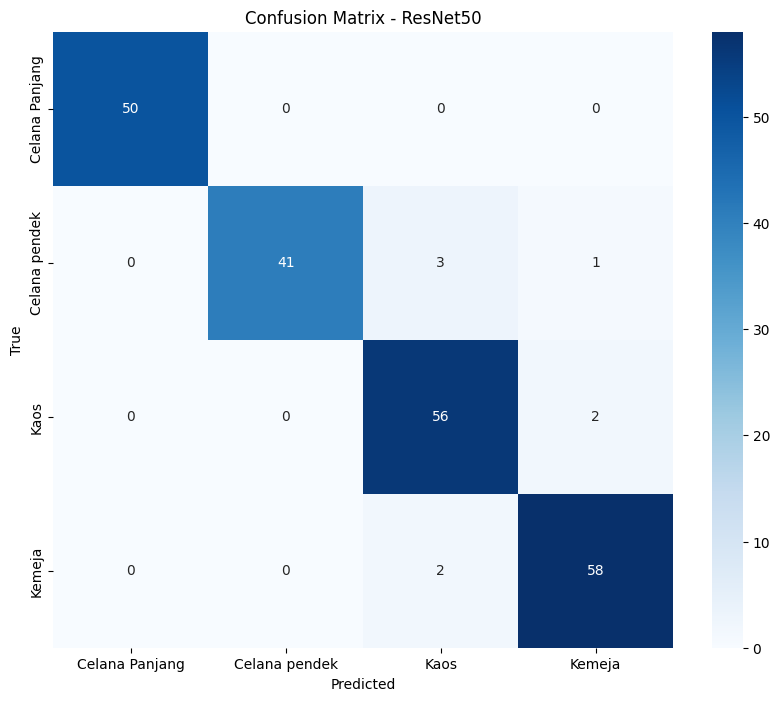


Visualisasi Training History:


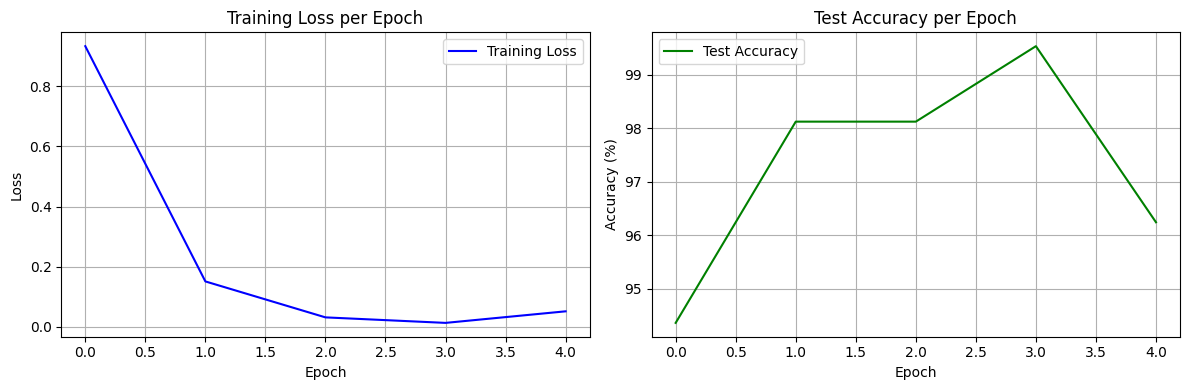

In [ ]:
# Confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix - ResNet50')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

def plot_training_history(train_losses, test_accuracies):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Plot training loss
    ax1.plot(train_losses, label='Training Loss', color='blue')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training Loss per Epoch')
    ax1.legend()
    ax1.grid(True)

    # Plot test accuracy
    ax2.plot(test_accuracies, label='Test Accuracy', color='green')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Test Accuracy per Epoch')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

print("\nVisualisasi Training History:")
plot_training_history(train_losses, test_accuracies)

In [ ]:
def predict_single_image(model, image_path, transform, classes):
    # Load dan preprocess gambar
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Tidak dapat membaca gambar {image_path}")
        return None

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    from PIL import Image
    image_pil = Image.fromarray(image)

    # Transformasi
    image_tensor = transform(image_pil).unsqueeze(0).to(device)

    # Predict
    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.softmax(outputs, dim=1)
        _, predicted_idx = torch.max(outputs, 1)

    # Get results
    predicted_class = classes[predicted_idx.item()]
    confidence = probabilities[0][predicted_idx].item() * 100

    return predicted_class, confidence, probabilities.cpu().numpy()[0]

In [ ]:
# Cari contoh gambar untuk testing
test_image_paths = []
for cls in classes:
    cls_dir = Path(dataset_path) / cls
    if cls_dir.exists():
        images = list(cls_dir.glob("*.jpg"))
        if images:
            test_image_paths.append(str(random.choice(images)))

# Lakukan prediksi untuk beberapa gambar
for img_path in test_image_paths[:3]:
    predicted_class, confidence, all_probs = predict_single_image(
        model, img_path, test_transform, classes
    )

    if predicted_class:
        print(f"\nGambar: {Path(img_path).name}")
        print(f"Predicted: {predicted_class}")
        print(f"Confidence: {confidence:.2f}%")

        # Tampilkan probabilitas untuk semua kelas
        print("Probabilities per class:")
        for cls, prob in zip(classes, all_probs):
            print(f"  {cls}: {prob*100:.2f}%")

def save_model(model, classes, save_path="resnet50_clothing.pth"):
    torch.save({
        'model_state_dict': model.state_dict(),
        'classes': classes,
        'input_size': 224
    }, save_path)

    print(f"\nModel disimpan sebagai: {save_path}")
    print(f"Ukuran file: {os.path.getsize(save_path) / (1024**2):.2f} MB")

save_model(model, classes, "resnet50_clothing_classifier.pth")


Gambar: panjang 5_aug_1.jpg
Predicted: Celana Panjang
Confidence: 99.90%
Probabilities per class:
  Celana Panjang: 99.90%
  Celana pendek: 0.01%
  Kaos: 0.03%
  Kemeja: 0.05%

Gambar: pendek 30.jpg
Predicted: Celana pendek
Confidence: 99.95%
Probabilities per class:
  Celana Panjang: 0.01%
  Celana pendek: 99.95%
  Kaos: 0.02%
  Kemeja: 0.02%

Gambar: Kaos 2_aug_1.jpg
Predicted: Kaos
Confidence: 100.00%
Probabilities per class:
  Celana Panjang: 0.00%
  Celana pendek: 0.00%
  Kaos: 100.00%
  Kemeja: 0.00%

Model disimpan sebagai: resnet50_clothing_classifier.pth
Ukuran file: 94.00 MB


In [ ]:
def load_trained_model(model_path, device='cpu'):

    checkpoint = torch.load(model_path, map_location=device)

    # Buat model baru
    model = create_resnet50_model(len(checkpoint['classes']))
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()

    return model, checkpoint['classes']

print(f"Final Test Accuracy: {test_accuracies[-1]:.2f}%")
print(f"Jumlah parameter: {sum(p.numel() for p in model.parameters()):,}")

Final Test Accuracy: 96.24%
Jumlah parameter: 24,559,172
